
# MNIST Hyperparameter Tuning with KerasTuner (RandomSearch)
**Course:** Deep Learning  
**Topic:** Single-layer dense classifier + hyperparameter tuning  
**Dataset:** MNIST  
**Author:** Jerome Benton  
**Run time:** ~5–10 minutes on CPU (depending on trials)

---

### Learning Objectives
By the end of this notebook you will be able to:
- Build a **single-layer dense** neural network (softmax regression) for MNIST.
- Use **KerasTuner RandomSearch** to tune model hyperparameters.
- Compare a quick **baseline** to a tuned configuration.
- Interpret tuner results and retrain the **best model** on the full training set.

> Tip: This notebook is designed for **VS Code**. Cells are short and self-contained so you can step through them easily.



## 1) Setup
Install and import dependencies. We use TensorFlow's Keras API and **KerasTuner** (imported as `keras_tuner`).


In [1]:

# If KerasTuner is missing, uncomment to install.
# (It's named 'keras-tuner' on pip but imported as 'keras_tuner'.)
# %pip install -q -U keras-tuner


In [2]:

import os, random, numpy as np
import tensorflow as tf

# KerasTuner imports
import keras_tuner as kt

# Reproducibility
SEED = 42
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

print(tf.__version__)


2025-09-13 13:22:15.534499: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-13 13:22:15.547907: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-13 13:22:15.562970: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-13 13:22:15.567283: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-13 13:22:15.578367: I tensorflow/core/platform/cpu_feature_guar

2.17.0



## 2) Load & preprocess MNIST
We normalize pixel values to `[0, 1]` and **flatten** images to 784-dim vectors for a single dense layer.
We'll also create a **train/validation/test** split.


In [3]:

from tensorflow.keras.datasets import mnist

# Load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize to [0,1] and reshape to (n_samples, 784)
x_train = (x_train.astype("float32") / 255.0).reshape(-1, 28*28)
x_test  = (x_test.astype("float32") / 255.0).reshape(-1, 28*28)

num_classes = 10
input_dim = x_train.shape[1]

# Create a validation split from the training data
# We'll hold out 10,000 examples for validation
x_val, y_val = x_train[-10000:], y_train[-10000:]
x_train, y_train = x_train[:-10000], y_train[:-10000]

x_train.shape, x_val.shape, x_test.shape


((50000, 784), (10000, 784), (10000, 784))


## 3) Quick baseline (no tuning)
A single Dense → Softmax layer is essentially **multinomial logistic regression**.
We will:
- Use 10 units (one per class)
- `adam` optimizer with default learning-rate
- `sparse_categorical_crossentropy` loss

This gives us a reference to beat.


In [4]:

from tensorflow import keras
from tensorflow.keras import layers

def build_baseline(input_dim, num_classes=10):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

baseline = build_baseline(input_dim, num_classes)
history_baseline = baseline.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=5,
    batch_size=128,
    verbose=0
)

print("Baseline val acc:", history_baseline.history["val_accuracy"][-1])
test_loss, test_acc = baseline.evaluate(x_test, y_test, verbose=0)
print("Baseline test acc:", test_acc)


I0000 00:00:1757787739.024984  492212 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-09-13 13:22:19.149741: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Baseline val acc: 0.9235000014305115
Baseline test acc: 0.9210000038146973



### Plot baseline learning curve


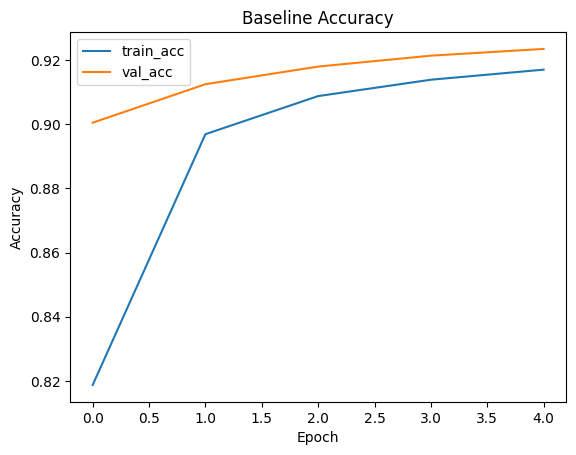

In [5]:

import matplotlib.pyplot as plt

plt.figure()
plt.plot(history_baseline.history["accuracy"], label="train_acc")
plt.plot(history_baseline.history["val_accuracy"], label="val_acc")
plt.title("Baseline Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()



## 4) KerasTuner: RandomSearch for a single-layer dense model
Our **search space** (all in a single Dense layer before softmax):
- `units`: number of hidden units *(0 means no hidden layer → pure softmax regression)*
- `activation`: nonlinearity for the hidden layer (if `units > 0`)
- `optimizer`: choice of optimizer
- `learning_rate`: learning rate for the chosen optimizer

We'll keep training settings fixed during search:
- `batch_size = 128`
- `epochs = 15`
- `objective = 'val_accuracy'`
- early stopping on validation loss


In [6]:

def model_builder(hp: kt.HyperParameters) -> keras.Model:
    units = hp.Int("units", min_value=0, max_value=256, step=32)
    activation = hp.Choice("activation", values=["relu", "tanh"])
    optimizer_name = hp.Choice("optimizer", values=["adam", "rmsprop", "sgd"])
    lr = hp.Choice("learning_rate", values=[1e-2, 5e-3, 1e-3, 5e-4, 1e-4])

    inputs = keras.Input(shape=(input_dim,))
    x = inputs

    # If units == 0, we skip hidden layer → softmax regression
    if units > 0:
        x = layers.Dense(units, activation=activation)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    # Create optimizer with chosen learning rate
    if optimizer_name == "adam":
        optimizer = keras.optimizers.Adam(learning_rate=lr)
    elif optimizer_name == "rmsprop":
        optimizer = keras.optimizers.RMSprop(learning_rate=lr)
    else:
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.0, nesterov=False)

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model



### Run the tuner
We try a small number of trials for classroom speed. Increase `max_trials` to search deeper.


In [7]:

MAX_TRIALS = 12  # adjust for deeper/shallower search
EXECUTIONS_PER_TRIAL = 1

tuner = kt.RandomSearch(
    hypermodel=model_builder,
    objective="val_accuracy",
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTIONS_PER_TRIAL,
    seed=SEED,
    directory="kt_mnist",
    project_name="single_dense_random"
)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

tuner.search_space_summary()

tuner.search(
    x_train, y_train,
    epochs=15,
    validation_data=(x_val, y_val),
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

tuner.results_summary()


Trial 12 Complete [00h 00m 09s]
val_accuracy: 0.9322999715805054

Best val_accuracy So Far: 0.9786999821662903
Total elapsed time: 00h 02m 11s
Results summary
Results in kt_mnist/single_dense_random
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 09 summary
Hyperparameters:
units: 224
activation: relu
optimizer: adam
learning_rate: 0.001
Score: 0.9786999821662903

Trial 04 summary
Hyperparameters:
units: 160
activation: relu
optimizer: adam
learning_rate: 0.001
Score: 0.9771000146865845

Trial 08 summary
Hyperparameters:
units: 224
activation: relu
optimizer: rmsprop
learning_rate: 0.0005
Score: 0.9768999814987183

Trial 00 summary
Hyperparameters:
units: 160
activation: relu
optimizer: rmsprop
learning_rate: 0.005
Score: 0.9749000072479248

Trial 05 summary
Hyperparameters:
units: 256
activation: relu
optimizer: rmsprop
learning_rate: 0.001
Score: 0.9747999906539917

Trial 01 summary
Hyperparameters:
units: 224
activation: relu
optimizer: rmsprop
learning


## 5) Evaluate the best model
We extract the best hyperparameters, rebuild the model, and evaluate on the **held-out test** set.


In [8]:

best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:")
for p in best_hp.values.keys():
    print(f"  {p}: {best_hp.get(p)}")

best_model = tuner.hypermodel.build(best_hp)

history_best = best_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=15,
    batch_size=128,
    callbacks=[early_stop],
    verbose=0
)

test_loss, test_acc = best_model.evaluate(x_test, y_test, verbose=0)
print(f"Best model test accuracy: {test_acc:.4f}")


Best hyperparameters:
  units: 224
  activation: relu
  optimizer: adam
  learning_rate: 0.001


Best model test accuracy: 0.9771



### Plot tuned model learning curve


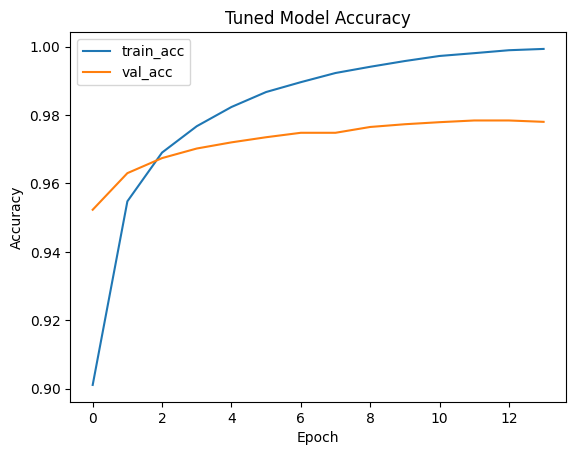

In [9]:

plt.figure()
plt.plot(history_best.history["accuracy"], label="train_acc")
plt.plot(history_best.history["val_accuracy"], label="val_acc")
plt.title("Tuned Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()



## 6) Baseline vs tuned: quick comparison


In [10]:

baseline_test_acc = baseline.evaluate(x_test, y_test, verbose=0)[1]
tuned_test_acc = best_model.evaluate(x_test, y_test, verbose=0)[1]

print(f"Baseline test acc: {baseline_test_acc:.4f}")
print(f"Tuned    test acc: {tuned_test_acc:.4f}")

improvement = 100.0 * (tuned_test_acc - baseline_test_acc)
print(f"Absolute improvement: {improvement:.2f} percentage points")


Baseline test acc: 0.9210
Tuned    test acc: 0.9771
Absolute improvement: 5.61 percentage points



## 7) Extensions / Exercises
- Add `l2` weight decay as a hyperparameter.
- Tune `batch_size` by defining a custom `HyperModel` with a custom `fit()`.
- Try **BayesianOptimization** or **Hyperband** in `keras_tuner`.
- Compare single-layer vs. two-layer dense networks under the same budget.
- Track experiments with CSVLogger and visualize trial-by-trial results.
